In [2]:
from OpInf import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import stiefel

import importlib
importlib.reload(stiefel)

from scipy.io import loadmat
from operators import ckron, ckron_indices

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scienceplots
plt.style.use(["science", "no-latex", "grid"])

check syl solve
True
here
True
6.346885283510603e-14
Use algebraic Stiefel log, metric alpha =  -0.0
dist 3.7699111843077575
NORM TEST1: 0.0
NORM TEST2: 3.436938234013809e-13
NORM TEST3: 7.794979939301783e-15


In [3]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example


In [4]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [5]:
mus = [1.1, 1.05, 1, 0.95, 0.9]
# Load data
T_end_train = 2
dt= 1e-3
Train_T = int(T_end_train/dt)

X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")[:, :Train_T+1, :]
X_all_p1per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_p1per.npy")[:, :Train_T+1, :]
X_all_n1per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_n1per.npy")[:, :Train_T+1, :]
X_all_p5per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_p5per.npy")[:, :Train_T+1, :]
X_all_n5per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_n5per.npy")[:, :Train_T+1, :]
# X_all_p10per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_p10per.npy")[:, :Train_T+1, :]
# X_all_n10per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_n10per.npy")[:, :Train_T+1, :]
# X_all_p20per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_p20per.npy")[:, :Train_T+1, :]
# X_all_n20per = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_n20per.npy")[:, :Train_T+1, :]

In [6]:
p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    "N": 2**7 + 1 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "BE",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [7]:
X_all_nominal.shape

(5, 2001, 130)

In [8]:
X_nominal = np.concatenate([X for X in X_all_nominal], axis=0).T
X_p1per = np.concatenate([X for X in X_all_p1per], axis=0).T
X_n1per = np.concatenate([X for X in X_all_n1per], axis=0).T
X_p5per = np.concatenate([X for X in X_all_p5per], axis=0).T
X_n5per = np.concatenate([X for X in X_all_n5per], axis=0).T

# X_p10per = np.concatenate([X for X in X_all_p10per], axis=0).T
# X_n10per = np.concatenate([X for X in X_all_n10per], axis=0).T
# X_p20per = np.concatenate([X for X in X_all_p20per], axis=0).T
# X_n20per = np.concatenate([X for X in X_all_n20per], axis=0).T


In [9]:
X_list = [X_p1per, X_n1per, X_p5per, X_n5per, X_nominal]
# X_list = [X_p10per, X_n10per, X_p20per, X_n20per, X_nominal]

X =  (130, 10005)
X_ref =  (130, 1)
S =  [373.48589453 193.79250042 112.618256    74.68230409  54.5426605 ]
idx =  5
rel_err_SVD[idx] =  0.027255029553820642
X =  (130, 10005)
X_ref =  (130, 1)


S =  [373.4575432  193.76583707 112.59430458  74.66158103  54.5228165 ]
idx =  5
rel_err_SVD[idx] =  0.02710653121793527
X =  (130, 10005)
X_ref =  (130, 1)
S =  [373.53941575 193.84291209 112.66357932  74.72139577  54.57988731]
idx =  5
rel_err_SVD[idx] =  0.027539846307704563
X =  (130, 10005)
X_ref =  (130, 1)
S =  [373.39731943 193.70927668 112.54353354  74.61750454  54.48036548]
idx =  4
rel_err_SVD[idx] =  0.03554286409289931
X =  (130, 10005)
X_ref =  (130, 1)
S =  [373.47185814 193.7792965  112.60639346  74.67204609  54.53284698]
idx =  5
rel_err_SVD[idx] =  0.02718131091630671


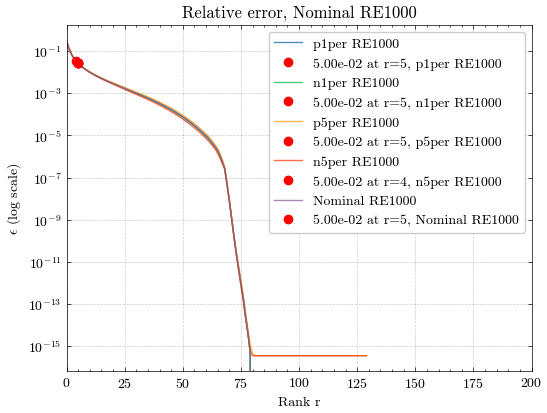

In [10]:
rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
names = [f'p1per RE1000', f'n1per RE1000', f'p5per RE1000', f'n5per RE1000', f'Nominal RE1000']
# names = [f'p10per RE1000', f'n10per RE1000', f'p20per RE1000', f'n20per RE1000', f'Nominal RE1000']

fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 5e-2 #r=5
# err_tol = 1e-2 #r=12
# err_tol = 1e-3 #r=32

# mus = [0.01] # only one mu for now

for i in range(len(X_list)):
    
    X = X_list[i]
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0], 1))
    
    print("X = ", X.shape)
    print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol:.2e} at r={idx}, {names[i]}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal RE1000")
    ax.legend()

In [11]:
idx_lst[-1]

5

In [12]:
# Model parameters
r = idx_lst[-1]
q_trunc = 2
# p = 3

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.1       # regularization parameter
max_iter = 100  # maximum number of iterations

Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []

for i in range(len(X_list)):
    # Procustes problem for each mu
    X = X_list[i]
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    print("X = ", X.shape)
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r + q_trunc]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    Poly = np.concatenate(polynomial_form(q, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(q)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)

    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization(X, X_ref, num_snapshots, max_iter, 1e-3, gamma, r, q, p, initial_Shat=None)

    # print("q = ", q.shape)
    # print("qbar = ", qbar.shape)

num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 17.4238%
num_snapshots:  10005
X =  (130, 10005)



Reconstruction error: 17.3809%
num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 17.5058%
num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 17.2909%
num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 17.4025%


In [13]:
Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")


Reconstruction error: 17.4025%


In [14]:
# Get nominal Reynolds for OpInf
X = X_list[-1][:, ]

In [15]:
Mp = len(mus)
Nsnapshots = X.shape[1]
dShatdt = []
Shat_lst = []
dSdt = []
for j in range(Mp):
    start_ind = int((j) * Nsnapshots/Mp)
    end_ind = int((j+1) * Nsnapshots/Mp)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
    ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
    dShatdt.append(ddtshat)
    ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    Shat_lst.append(q[:, ind])
    dSdt.append(ddts)
    

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005


In [16]:
import importlib
import OpInf
# import reloading
# reload the whole OpInf module
importlib.reload(OpInf)
from OpInf import *


In [17]:
def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

Shat_py = np.concatenate(Shat_lst, axis=1)
dShatdt_py = np.concatenate(dShatdt, axis=1).T
dSdt_py = np.hstack(dSdt)

print("Shape of Shat_py: ", Shat_py.shape)
print("Shape of dShatdt_py: ", dShatdt_py.shape)
# [operators] = inferOperators_NL(Shat, U, params, dShatdt);

operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
# operators = infer_operators_nl(q, None, config['params'], /dShatdt_py)

Shape of Shat_py:  (5, 10000)
Shape of dShatdt_py:  (10000, 5)
Generating ghat ...


drp:  40
Obtained data matrix...


In [ ]:
config['robparams'] = {
    "r": int(r)
}

N = int(config['N'])
dt = config['dt']
T_end = config['T_end']
mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
Mp = config['Mp']
K = int(config['K'])
DS = config['DS']
params = config['params']  # This will be a dictionary in Python
robparams = config['robparams']  # This will be a dictionary in Python


coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
time_domain = np.arange(0, T_end, dt)
train_size = Shat_py.shape[1]

# regs = [1e1, 3e3, 1e9]
# regs = [0.001, 20, 1e5]
Shat_true = Shat_lst[2]
# regs_product = [1e-3, 1e1, 3, 1e1, 1e4, 10, 1e1, 1e7, 7]

regs_product = [10, 10, 1, 43.939705607607905, 43.939705607607905, 1, 27.825594022071257, 27.825594022071257, 1] # for r=5
# regs_product = [10, 10, 1, 129.1549665014884, 129.1549665014884, 1, 1000000, 1000000, 1] # for r=12
# regs_product = [10, 10, 1, 4.47213595e+01, 4.47213595e+01, 1, 1.00000000e+07, 1.00000000e+07, 1] # for r=32
# [1.00000000e+01, 4.47213595e+01, 1.00000000e+07]
# [10.0, 129.1549665014884, 1000000.0]

# [10.0, 43.939705607607905, 27.825594022071257]
# regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
# regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
# regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)


coord =  (130,)
Constructing least-squares solver, r=5
TRAINING 1 ROMS
(1/1) Testing ROM with (10.0, 43.939705607607905, 27.825594022071257)
Generating ghat ...
drp:  40
Obtained data matrix...
Regularization parameters:  10.0 43.939705607607905 27.825594022071257
Solving...
Solved!
Integrating...
Bound check passed


In [ ]:
print("Errors:, ", errors)
print("regs: ", regs)

Errors:,  0.007113723773443704
regs:  [10.0, 43.939705607607905, 27.825594022071257]


In [ ]:
# regs = [0.0005399173326341194, 23.61197176062329, 202651972.5062846]

params['lambda1'] = regs[0]
params['lambda2'] = regs[1]
if len(regs) > 2:
    params['lambda3'] = regs[2]

# params['lambda1'] = (5e-2)**2
# params['lambda2'] = (5e-2)**2
# if len(regs) > 2:
#     params['lambda3'] = regs[2]
operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)

Generating ghat ...
drp:  40
Obtained data matrix...
Regularization parameters:  10.0 43.939705607607905 27.825594022071257
Solving...
Solved!


In [ ]:
from stiefel import *
import importlib
importlib.reload(stiefel)
N_stiefel_samples = 1000

V_combined_lst = [np.concatenate([Vr, Vbar], axis=1) for Vr, Vbar in zip(Vr_lst, Vbar_lst)]

# Generate the samples and split them into two arrays
stiefel_samples_combined = stiefel.gen_stiefel_samples(N_stiefel_samples, V_combined_lst, tau=0.00001, metric_alpha=0.000000000)
stiefel_samples_Vr = np.array([sample[:, :r] for sample in stiefel_samples_combined])
stiefel_samples_Vbar = np.array([sample[:, r:r+q_trunc] for sample in stiefel_samples_combined])

Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 30 08:51:26 PM: Your problem has 4 variables, 3 constraints, and 0 parameters.
(CVXPY) Apr 30 08:51:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 30 08:51:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 30 08:51:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 30 08:51:26 PM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------------------------------------------------

In [ ]:
frechet_mean = calc_frechet_mean_mat(stiefel_samples_combined, V_combined_lst[-1], eps=1e-2, tau=1e-3)

In [ ]:
Vr_frechet_mean = frechet_mean[0][:, :r]
Vbar_frechet_mean = frechet_mean[0][:, r:]

In [ ]:
# Compute norm difference between Vr samples and nominal Vr for all stiefel samples
norm_diffs_numerator = [np.linalg.norm(Vr_lst[-1] - sample, 'fro')**2 for sample in stiefel_samples_Vr]
norm_diffs_denominator = np.linalg.norm(Vr_lst[-1], 'fro')**2
norm_diffs = np.sqrt(np.sum(norm_diffs_numerator))/ np.sqrt(norm_diffs_denominator)

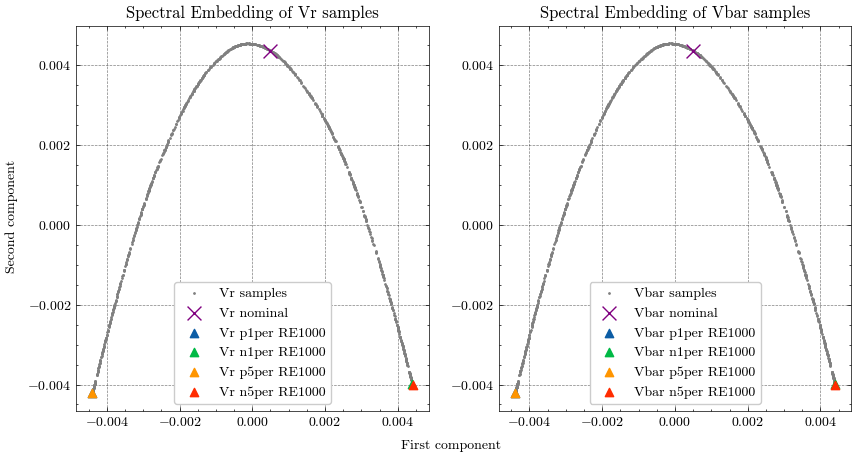

In [ ]:
# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst], axis=1)
flat_Vr_frechet_mean = Vr_frechet_mean.flatten()[:, None]
flat_Vbar_frechet_mean = Vbar_frechet_mean.flatten()[:, None]
rob_Vr_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vr] + [flat_Vr_arr] + [flat_Vr_frechet_mean], axis=1)
rob_Vbar_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vbar] + [flat_Vbar_arr] + [flat_Vbar_frechet_mean], axis=1)

from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

# colors = 
colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst) - 1))


# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(rob_Vr_all.T)
embedding_Vbar = embedder.fit_transform(rob_Vbar_all.T)

# Plot the embeddings
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(embedding_Vr[:-2, 0], embedding_Vr[:-2, 1], color='gray', s=1, label='Vr samples')
plt.scatter(embedding_Vr[-2, 0], embedding_Vr[-2, 1], color='purple', label='Vr nominal', marker='x', s=100)
plt.scatter(embedding_Vr[-1, 0], embedding_Vr[-1, 1], color='cyan', label='Vr Frechet mean', marker='x', s=100)


for i in range(1, len(Vr_lst) - 1):
    # plt.scatter(embedding_Vr[-i-3, 0], embedding_Vr[-i-3, 1], color=colors[i], label=f"Vr {names[i]}", marker='^')
    plt.scatter(embedding_Vr[-i-2, 0], embedding_Vr[-i-2, 1], label=f"Vr {names[-i]}", marker='^', color=colors[i])

plt.legend()
plt.title('Spectral Embedding of Vr samples')
# plt.xlabel('First component')
# plt.ylabel('Second component')


plt.subplot(1, 2, 2)
plt.scatter(embedding_Vbar[:-2, 0], embedding_Vbar[:-2, 1], color='gray', s=1, label='Vbar samples')
plt.scatter(embedding_Vbar[-2, 0], embedding_Vbar[-2, 1], color='purple', label='Vbar nominal', marker='x', s=100)
plt.scatter(embedding_Vbar[-1, 0], embedding_Vbar[-1, 1], color='cyan', label='Vbar Frechet mean', marker='x', s=100)

for i in range(1,len(Vbar_lst)-1):
    # plt.scatter(embedding_Vbar[-i-3, 0], embedding_Vbar[-i-3, 1], color=colors[i], label=f"Vbar {names[i]}", marker='^')
    plt.scatter(embedding_Vbar[-i-2, 0], embedding_Vbar[-i-2, 1], label=f"Vbar {names[-i]}", marker='^', color=colors[i])
    print(f"Vbar {names[-i]}")

plt.legend()
plt.title('Spectral Embedding of Vbar samples')

# plt.xlabel('First component')
# plt.ylabel('Second component')

# Add common x and y labels
fig.text(0.5, 0.04, 'First component', ha='center', va='center')
fig.text(0.06, 0.5, 'Second component', ha='center', va='center', rotation='vertical')
plt.show()

In [23]:
modelform = config['params']['modelform']

def rhs(t, state, operators, multi_indices, modelform, input_func=None):
    r"""Evaluate the right-hand side of the model by applying each operator
    and summing the results.

    This is the function :math:`\Ophat(\qhat, \u)`
    where the model can be written as one of the following:

    * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
    * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
    * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

    Parameters
    ----------
    state : (r,) ndarray
        State vector.
    input_ : (m,) ndarray or None
        Input vector corresponding to the state.

    Returns
    -------
    evaluation : (r,) ndarray
        Evaluation of the right-hand side of the model.
    """
    state = np.atleast_1d(state)
    
    # print("State shape: ", state.shape)
    
    out = np.zeros(state.shape, dtype=float)
    # gs = gen_poly(state[:, None], p=2)  # Assuming gen_poly is designed for column vector input
    
    # print("Solving for regularization parameters: ", params['lambda1'], params['lambda2'], params['lambda3'])
    
    if 'L' in modelform:
        # print("adding A")
        out += operators['A'] @ state
    
    if 'Q' in modelform:
        # ssq = get_x_sq(state[:, None].T).T  # Assuming get_x_sq can handle the shape
        # out += operators['F'] @ ssq.flatten()
        # print("adding F")
        mask = ckron_indices(state.shape[0])
        out += (operators["F"] @ np.prod(state[mask], axis=1))
        
    if 'P' in modelform:
        gs = gen_poly(state[:, None], p=p, multi_indices=multi_indices)  # Assuming gen_poly is designed for column vector input
        out += (operators['P'] @ gs).flatten()
        
    if 'C' in modelform:
        out += operators['C'].flatten()
    
    return out


In [24]:
X_all_nominal_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")

In [25]:
X_all_nominal_full.shape

(5, 8000, 130)

In [26]:
T_end_index = int(T_end/dt)

In [27]:
# nominal s_rec_full

Vr = Vr_lst[-1]
Vbar = Vbar_lst[-1]


coord = np.linspace(0, 1, N)
# print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()

T_end_full = 8
time_domain_full = np.arange(0, T_end_full, dt)

train_size = Shat_py.shape[1]

multi_indices = generate_multi_indices_efficient(len(q0), p=p)


modelform = config['params']['modelform']
out_full = scipy.integrate.solve_ivp(
            rhs,  # Integrate this function
            [time_domain_full[0], time_domain_full[-1]],  # over this time interval
            q0,  # from this initial condition
            t_eval=time_domain_full,  # evaluated at these points
            args=[operators, multi_indices, modelform, None],  # additional arguments to rhs
            
        )

s_hat_full = out_full.y
poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
Xi = Xi_lst[-1] # the nominal Xi
# print("Poly shape: ", poly_full.shape)

s_rec_full_nominal = X_ref + Vr @ s_hat_full + Vbar @ Xi @ poly_full


abs_error_full_nominal = np.abs(X_all_nominal_full[2].T - s_rec_full_nominal)
relative_error_testing_window_nominal = np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:] - s_rec_full_nominal[:, T_end_index:], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:], 'fro')
relative_error_training_window_nominal = np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index] - s_rec_full_nominal[:, :T_end_index], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index], 'fro')


In [28]:
import tqdm

N_samples = 1000
abs_error_full_lst = []
relative_error_testing_window_lst = []
relative_error_training_window_lst = []
s_rec_full_lst = []

for i in tqdm.tqdm(range(N_samples)):
    # # randomly choose 1 from stiefel_samples_Vr and 1 from stiefel_samples_Vbar
    # idx_Vr = np.random.randint(0, N_stiefel_samples)
    # idx_Vbar = np.random.randint(0, N_stiefel_samples)
    
    Vr_sample = stiefel_samples_Vr[i]
    Vbar_sample = stiefel_samples_Vbar[i]
    

    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(c) for c in coord])
    q0 = Vr_sample.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    train_size = Shat_py.shape[1]

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    

    modelform = config['params']['modelform']
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, multi_indices, modelform, None],  # additional arguments to rhs
                
            )
    
    s_hat_full = out_full.y
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    Xi = Xi_lst[-1] # the nominal Xi
    # print("Poly shape: ", poly_full.shape)

    s_rec_full = X_ref + Vr_sample @ s_hat_full + Vbar_sample @ Xi @ poly_full
    
    
    abs_error_full = np.abs(X_all_nominal_full[2].T - s_rec_full)
    relative_error_testing_window = np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:], 'fro')
    relative_error_training_window = np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index], 'fro')
    
    abs_error_full_lst.append(abs_error_full)
    relative_error_testing_window_lst.append(relative_error_testing_window)
    relative_error_training_window_lst.append(relative_error_training_window)
    s_rec_full_lst.append(s_rec_full)
    
    

100%|██████████| 1000/1000 [00:15<00:00, 66.64it/s]


In [29]:
# mean relative error across the testing window
mean_relative_error_testing = np.mean(relative_error_testing_window_lst)
std_relative_error_testing = np.std(relative_error_testing_window_lst)
# coeff_var = std_relative_error_testing / mean_relative_error_testing
print(f"Mean relative error: {mean_relative_error_testing:.4%}")
print(f"Std relative error: {std_relative_error_testing:.4%}")
# print(f"Coefficient of variation: {coeff_var:.4%}")

Mean relative error: 12.6225%
Std relative error: 0.0227%


In [30]:
X_all_nominal.shape

(5, 2001, 130)

In [31]:
# coefficient of variation of s_rec_full
# coeff_var_s_rec_full = np.std(s_rec_full_lst, axis=0) / (np.mean(s_rec_full_lst, axis=0))
std_s_rec_full = np.std(s_rec_full_lst, axis=0)
std_s_rec_full_testing = std_s_rec_full[T_end_index:]
std_s_rec_full_training = std_s_rec_full[:T_end_index]

In [32]:
#  mean reconstruction
mean_s_rec_full = np.mean(s_rec_full_lst, axis=0)
mean_s_rec_full_testing = mean_s_rec_full[T_end_index:]
mean_s_rec_full_training = mean_s_rec_full[:T_end_index]

In [33]:
# replace NaN with 0
# coeff_var_s_rec_full = np.nan_to_num(coeff_var_s_rec_full)

In [34]:
# calculate 95% confidence interval
confidence_interval = 1.96 * std_s_rec_full / np.sqrt(N_samples)

X =  (8000, 130)
Y =  (8000, 130)
s_ref_all[i] =  (0, 8000)


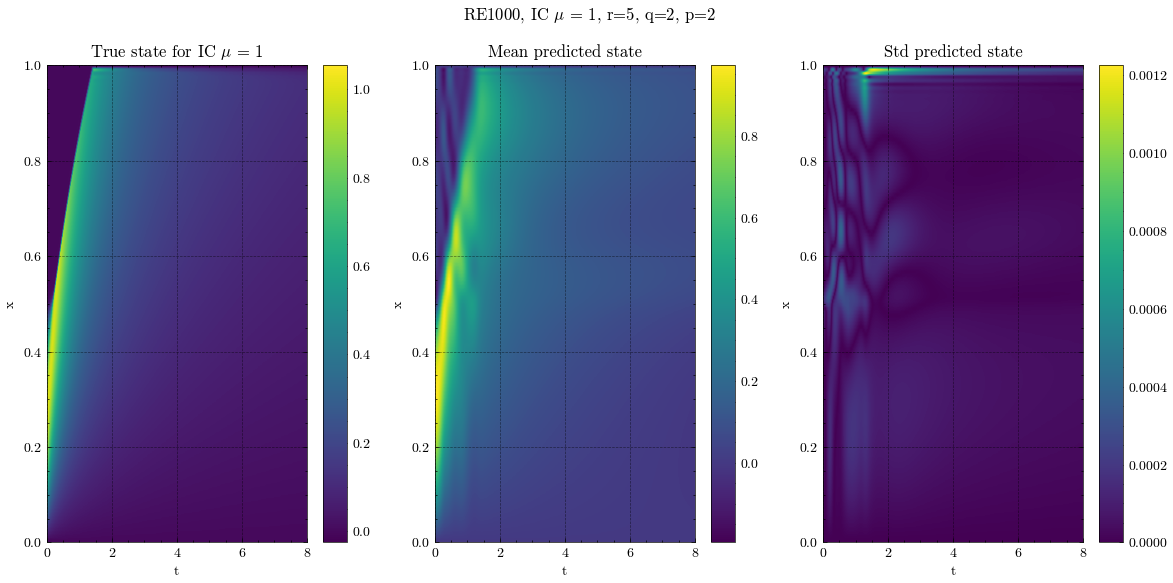

In [35]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(mean_s_rec_full.shape[0])), np.linspace(0.0, 1.0, mean_s_rec_full.shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", mean_s_rec_full_testing.shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    
    c0 = axs[0].imshow(X_all_nominal_full[2].T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c0, ax=axs[0], orientation='vertical')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'True state for IC $\mu$ = {mus[2]}')
    
    c1 = axs[1].imshow(mean_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c1, ax=axs[1], orientation='vertical')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Mean predicted state')
    
    c2 = axs[2].imshow(std_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    fig.colorbar(c2, ax=axs[2], orientation='vertical')
    axs[2].set_xlabel('t')
    axs[2].set_ylabel('x')
    axs[2].set_title(f'Std predicted state')
    
    
    # fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    # fig.colorbar(c2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.suptitle(f"RE1000, IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}")
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'RE1000, nominal model solution for IC $\\mu$ = 1, r=5, q=2, p=2')

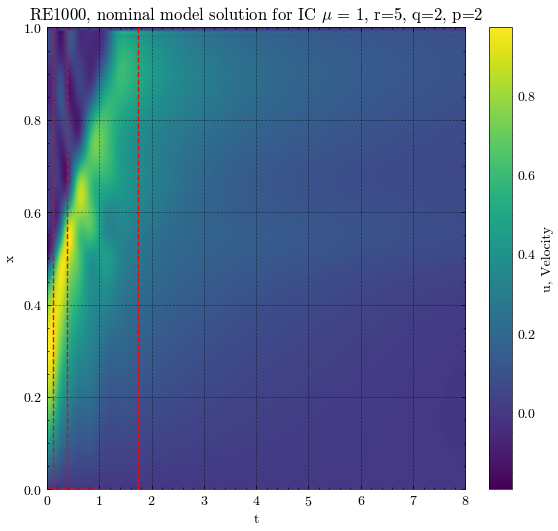

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


# plot 95% confidence interval of the solution
fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
upper_bound = mean_s_rec_full + confidence_interval
lower_bound = mean_s_rec_full - confidence_interval

XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(s_rec_full_nominal.T.shape[0])), np.linspace(0.0, 1.0, s_rec_full_nominal.T.shape[1]))

# surf = ax.plot_surface(XX, YY, s_rec_full_nominal, cmap='viridis', alpha=0.7)

contour = ax.imshow(s_rec_full_nominal, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=np.min(s_rec_full_nominal.T), vmax=np.max(s_rec_full_nominal.T)), cmap='viridis'), ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('u, Velocity')


# draw vertical plane at t=0.125, 0.375, 1,75
for t in [0.125, 0.375, 1.75]:
    ax.plot([t, t], [0, 1], [0, 0], color='red', linestyle='--')


ax.set_xlabel('t')
ax.set_ylabel('x')
# ax.set_zlabel('u')
ax.set_title(f'RE1000, nominal model solution for IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}')


Lower and upper bounds are different
Lower and upper bounds are different
Lower and upper bounds are different


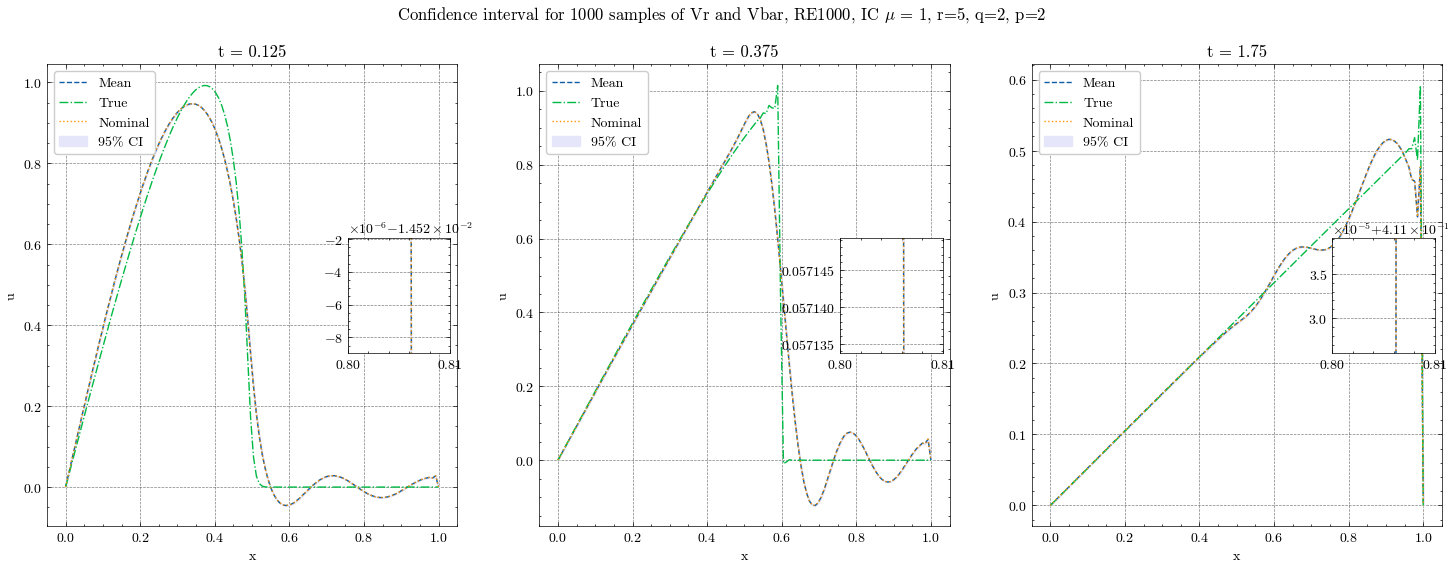

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Example setup (you'll need to define mean_s_rec_full, lower_bound, and upper_bound appropriately)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, t in enumerate([0.125, 0.375, 1.75]):
    ax = axs[i]
    t_index = int(t / dt)  # Ensure dt is defined and properly calculated

    # Main plot
    x_values = np.linspace(0, 1, mean_s_rec_full.shape[0])
    mean_line = mean_s_rec_full[:, t_index]
    nominal_line = s_rec_full_nominal[:, t_index]
    true_line = X_all_nominal_full[2].T[:, t_index]
    lower_line = lower_bound[:, t_index]
    upper_line = upper_bound[:, t_index]
    
    ax.plot(x_values, mean_line, label='Mean', linestyle="--")
    ax.plot(x_values, true_line, label='True', linestyle="-.")
    ax.plot(x_values, nominal_line, label='Nominal', linestyle=":")
    ax.fill_between(x_values, lower_line, upper_line, alpha=1, label='95% CI', color='lavender')
    ax.set_title(f"t = {t}")
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend(loc="upper left")

    # Create an inset axis
    axins = inset_axes(ax, width="25%", height="25%", loc='center right')

    # Plot the same data on the inset
    axins.plot(x_values, mean_line, linestyle="--")
    axins.plot(x_values, true_line, linestyle="-.")
    axins.plot(x_values, nominal_line, linestyle=":")
    
    if np.allclose(lower_line, upper_line):
        print("Lower and upper bounds are the same")
        axins.plot(x_values, lower_line, color='lavender')
    else:
        print("Lower and upper bounds are different")
        axins.fill_between(x_values, lower_line, upper_line, color='lavender', alpha=1)

    # Zoom-in range for the x-axis
    focus_x_min, focus_x_max = 0.8, 0.81
    axins.set_xlim(focus_x_min, focus_x_max)
    axins.set_ylim(np.min(lower_line), np.max(upper_line))

    # Dynamically determine the y-range based on the focus area
    mask = (x_values >= focus_x_min) & (x_values <= focus_x_max)
    focus_y_min = min(np.min(lower_line[mask]), np.min(mean_line[mask]))
    focus_y_max = max(np.max(upper_line[mask]), np.max(mean_line[mask]))
    y_margin = (focus_y_max - focus_y_min) * 0.1  # Adjust margin
    axins.set_ylim(focus_y_min - y_margin, focus_y_max + y_margin)

    # Optionally remove tick labels to declutter
    axins.xaxis.set_tick_params(labelbottom=True)
    axins.yaxis.set_tick_params(labelleft=True)

# plt.tight_layout()
plt.suptitle(f"Confidence interval for 1000 samples of Vr and Vbar, RE1000, IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}")
plt.show()


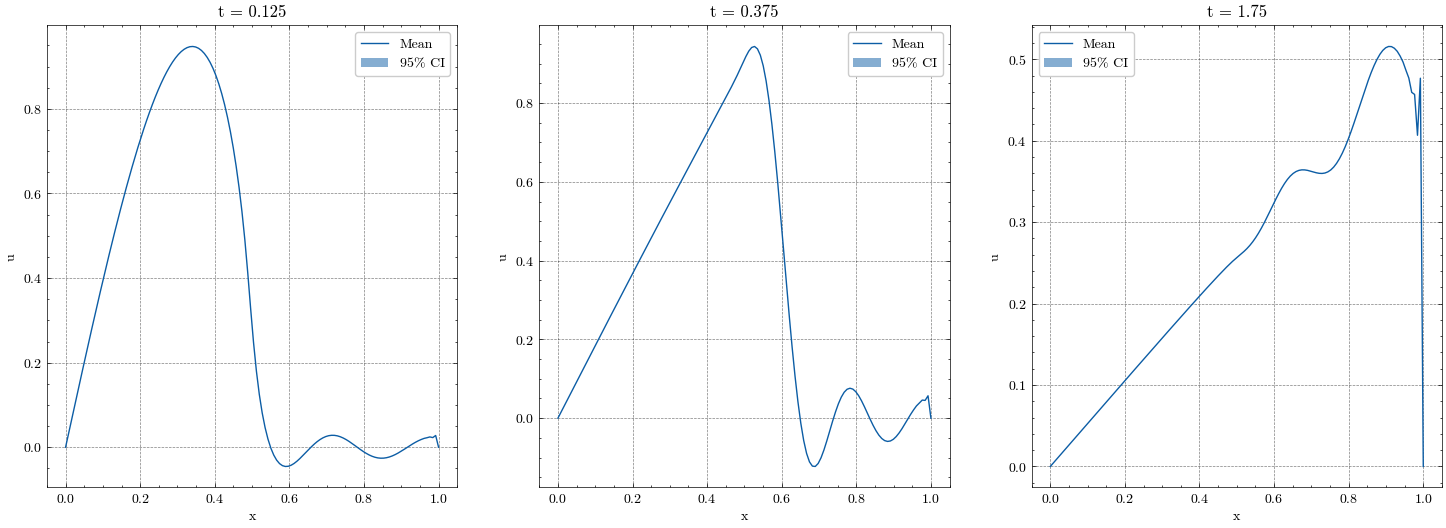

In [38]:
# plot the 95% confidence interval at time t=0.125, 0.375, 1.75
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, t in enumerate([0.125, 0.375, 1.75]):
    ax = axs[i]
    t_index = int(t / dt)
    ax.plot(np.linspace(0, 1, mean_s_rec_full.shape[0]), mean_s_rec_full[:, t_index], label='Mean')
    ax.fill_between(np.linspace(0, 1, mean_s_rec_full.shape[0]), lower_bound[:, t_index], upper_bound[:, t_index], alpha=0.5, label='95% CI')
    ax.set_title(f"t = {t}")
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()

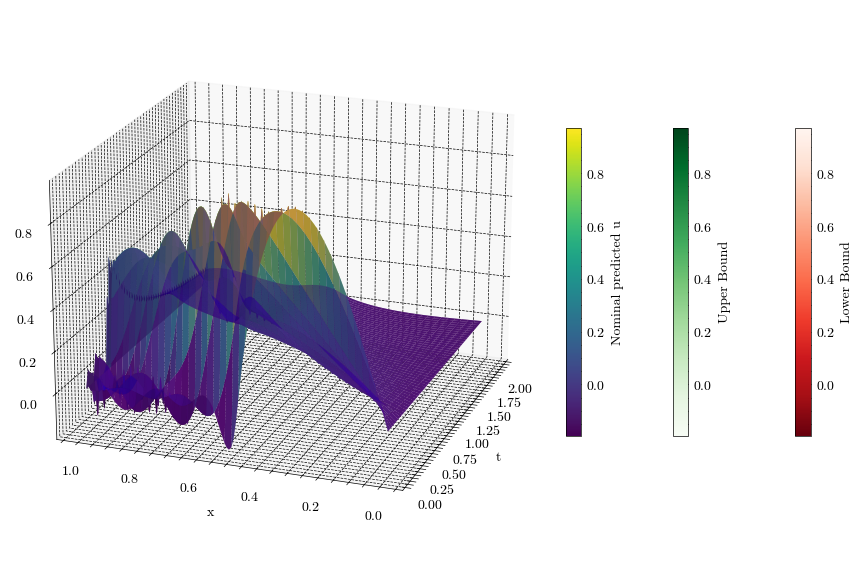

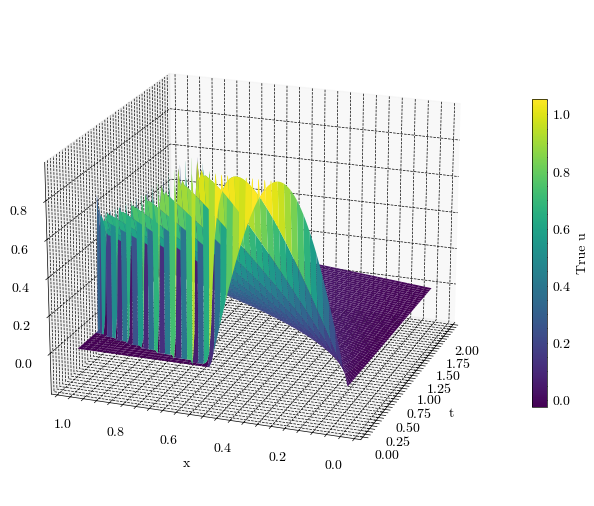

In [39]:
# lower bound
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
lower_surf = ax.plot_surface(XX, YY, lower_bound, color='red', alpha=0.2)
lower_colorbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=np.min(lower_bound), vmax=np.max(lower_bound)), cmap='Reds_r'), ax=ax, shrink=0.5, pad=0.005)
lower_colorbar.set_label('Lower Bound')
# upper bound
upper_surf = ax.plot_surface(XX, YY, upper_bound, color='blue', alpha=0.2)
upper_colorbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=np.min(upper_bound), vmax=np.max(upper_bound)), cmap='Greens'), ax=ax, shrink=0.5, pad=0.01)
upper_colorbar.set_label('Upper Bound')

surf = ax.plot_surface(XX, YY, s_rec_full_nominal, cmap='viridis', alpha=1)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=np.min(s_rec_full_nominal), vmax=np.max(s_rec_full_nominal)), cmap='viridis'), ax=ax, orientation='vertical', shrink=0.5, pad=0.01)
cbar.set_label('Nominal predicted u')

ax.set_xlabel('t')
ax.set_ylabel('x')

# rotate view
ax.view_init(20, 200)

# plot true surface for comparison
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
surf_true = ax.plot_surface(XX, YY, X_all_nominal_full[2].T, cmap='viridis', alpha=1)
cbar_true = fig.colorbar(ScalarMappable(norm=Normalize(vmin=np.min(X_all_nominal_full[2].T), vmax=np.max(X_all_nominal_full[2].T)), cmap='viridis'), ax=ax, orientation='vertical', shrink=0.5)
cbar_true.set_label('True u')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlim([np.min(lower_bound), np.max(upper_bound)])

# rotate view
ax.view_init(20, 200)
